## Introduction

A brief explanatory analysis is done for the following dataset:

 https://data.opencity.in/dataset/map-lakes-streams-bengaluru-urban-within-bbmp-area

The source map is prepared by:

Lakes and Streams Map Prepared by ATREE-CSEI (Ashoka Trust for Research in Ecology and the Environment).

More specifically, some visualisations both static and dynamic will be given.

Also, the focus will be on the West area of Bangalore and more specifically the following four lakes are of interest:

- Herohalli Lake

- Mallathahalli Lake

- Srigandhakavalu Karabu Katte

- Ullalu lake-2

## Installing the Python packages and loading them

In [1]:
!pip install beautifulsoup4 contextily geopandas folium mapclassify osmnx --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 25.0 MB/s eta 0:00:00


In [2]:
import re
from pathlib import Path
from urllib.request import urlopen, urlretrieve

import contextily as cx
import folium
import geopandas as gpd
import mapclassify
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
import osmnx as ox
import shapely


from bs4 import BeautifulSoup

## Reading in the data

In [3]:
link = "https://data.opencity.in/dataset/map-lakes-streams-bengaluru-urban-within-bbmp-area"
with urlopen(link) as x:
     data = x.read().decode('utf-8')
# print(data)

In [4]:
soup = BeautifulSoup(data)

In [5]:
list_url = []
for link in soup.findAll('a', attrs={'href': re.compile("^https://data")}):
  httpslink = link['href']
  list_url.append(httpslink)

In [6]:
list_url_unique = list(set(list_url))
list_url_unique

['https://data.opencity.in/dataset/b0f68537-2bce-4659-9171-9fb0ed3e4bcb/resource/d936310f-aba1-4b2b-aa34-663977917df7/download/bbmp_lakes_masterlist-final.kml',
 'https://data.opencity.in/dataset/b0f68537-2bce-4659-9171-9fb0ed3e4bcb/resource/dae235c7-89a9-48de-be2c-5c19621b1ecb/download/bbmp_lakes_streams.kml',
 'https://data.opencity.in/dataset/b0f68537-2bce-4659-9171-9fb0ed3e4bcb/resource/23141cb5-471e-4796-af80-4311819fd031/download/bbmp_streamnetwork.kml']

Make a data directory:

In [7]:
def create_directory(output_path:Path)-> None:
  """

  """
  try:
    output_path.mkdir()
    print(f"Directory '{output_path}' created.")
  except FileExistsError:
    print(f"Directory '{output_path}' already exists.")
  except PermissionError:
    print(f"Permission denied: Unable to create '{output_path}'.")
  except Exception as e:
    print(f"An error occurred: {e}")

In [8]:
output_path = Path('data')
create_directory(output_path)

Directory 'data' created.


Read in the lakes dataset:

In [9]:
# https://stackoverflow.com/questions/33131778/extract-a-list-item-in-python-that-contains-a-string-without-list-comprehension
lake_link = list(filter(lambda x: 'masterlist-final' in x, list_url_unique))[0]
lake_link

'https://data.opencity.in/dataset/b0f68537-2bce-4659-9171-9fb0ed3e4bcb/resource/d936310f-aba1-4b2b-aa34-663977917df7/download/bbmp_lakes_masterlist-final.kml'

In [10]:
out_path_file = output_path / lake_link.split("/")[-1]
out_path_file

PosixPath('data/bbmp_lakes_masterlist-final.kml')

Retrieve the link:

In [11]:
urlretrieve(lake_link, out_path_file)

(PosixPath('data/bbmp_lakes_masterlist-final.kml'),
 <http.client.HTTPMessage at 0x7c495b319570>)

In [12]:
lakes = gpd.read_file(out_path_file)
lakes.head()


,Name,Description,geometry
0,Alahalli Kere,,"MULTIPOLYGON Z (((77.56546 12.86654 0, 77.5654..."
1,Doddakallasandra kere,,"MULTIPOLYGON Z (((77.5626 12.88125 0, 77.5626 ..."
2,Thalagattapura lake,,"MULTIPOLYGON Z (((77.52983 12.86587 0, 77.5304..."
3,Kembathahali kere,,"MULTIPOLYGON Z (((77.57719 12.85765 0, 77.5767..."
4,Vajarahalli Govt.Katte,,"MULTIPOLYGON Z (((77.54379 12.86789 0, 77.5434..."


In [13]:
print(f'There are {lakes.shape[0]} lakes in the dataset.')

There are 181 lakes in the dataset.


Read in the other two datasets too

In [14]:
streamlink = list(filter(lambda x: 'streamnetwork' in x, list_url_unique))[0]
out_path_file_stream = output_path / streamlink.split("/")[-1]
urlretrieve(streamlink, out_path_file_stream)

(PosixPath('data/bbmp_streamnetwork.kml'),
 <http.client.HTTPMessage at 0x7c495b4d3190>)

In [15]:
streams = gpd.read_file(out_path_file_stream)
streams.head()

,Name,Description,geometry
0,,,"LINESTRING (77.57652 13.1427, 77.57652 13.1424..."
1,,,"LINESTRING (77.5768 13.14243, 77.5768 13.14215..."
2,,,"LINESTRING (77.57652 13.13909, 77.57652 13.138..."
3,,,"LINESTRING (77.57234 13.13743, 77.57235 13.13743)"
4,,,"LINESTRING (77.57791 13.1377, 77.57791 13.1374..."


In [16]:
# streams.plot()

In [17]:
print(f'There are {streams.shape[0]} streams in the city.')

There are 3927 streams in the city.


## Static plots: Plotting with Geopandas and matplotlib

In [18]:
print(f'The coordinate system is {lakes.crs}.')
print(f'The coordinate system is {streams.crs}.')


The coordinate system is EPSG:4326.
The coordinate system is EPSG:4326.


Extract the lakes of interest for our study:

In [19]:
lakes_interest = lakes[lakes['Name'].isin(['Herohalli Lake', 'Mallathahalli Lake', 'Srigandhakavalu Karabu Katte', 'Ullalu lake-2'])]
lakes_interest

,Name,Description,geometry
125,Herohalli Lake,,"MULTIPOLYGON Z (((77.4892 12.98723 0, 77.48904..."
152,Mallathahalli Lake,,"MULTIPOLYGON Z (((77.49567 12.96748 0, 77.4965..."
158,Ullalu lake-2,,"MULTIPOLYGON Z (((77.48079 12.95998 0, 77.4804..."
162,Srigandhakavalu Karabu Katte,,"MULTIPOLYGON Z (((77.50024 12.98439 0, 77.5002..."


In [167]:
#lakes_interest.plot()

Add the Bangalore shape file to this. A shortcut is to use the osmnx library:

In [20]:
bangalore = ox.geocode_to_gdf("Bangalore, India")

Add this also to the map and create a directory where you will save the images:

In [21]:
output_path = Path('images')
create_directory(output_path)

Directory 'images' created.


In [22]:
output_image = output_path / 'lakes_streams_bangalore.png'
output_image

PosixPath('images/lakes_streams_bangalore.png')

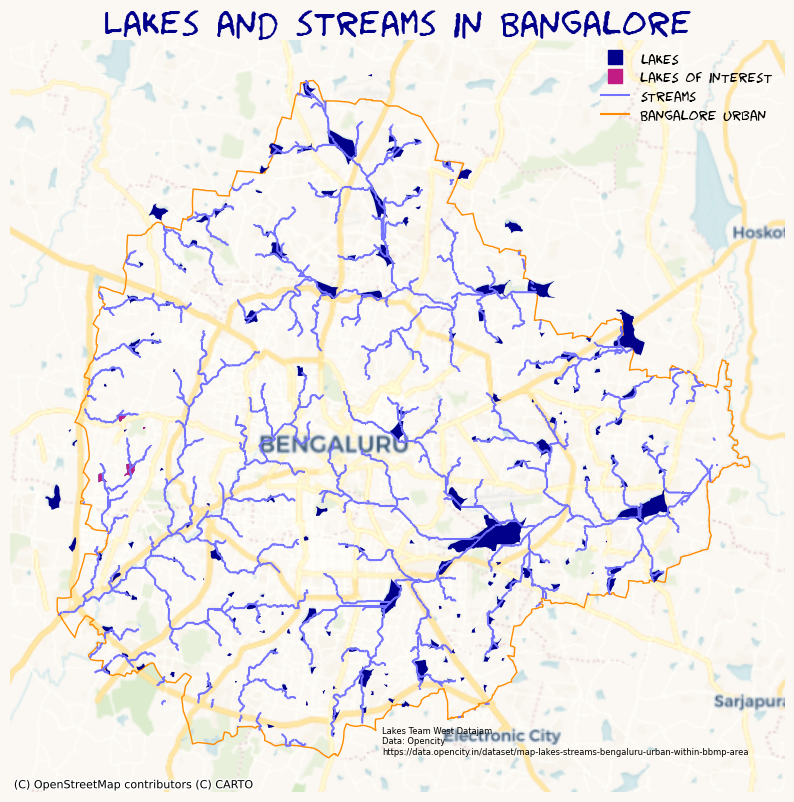

In [23]:
fig, ax = plt.subplots(figsize = (10,10), facecolor = '#FBF8F3')
plt.title('Lakes and streams in Bangalore', font = 'fantasy',color = 'darkblue', fontsize = 25)
bangalore.plot(ax=ax, edgecolor='darkorange', facecolor = 'none')

lakes.plot(ax=ax, color = 'darkblue', label= 'lakes')
streams.plot(ax=ax, color = '#7373FF', label = 'streams')
lakes_interest.plot(ax=ax, color = '#c11c84', label = '4 lakes')

# Customize the legend:
# https://stackoverflow.com/questions/78048623/how-can-i-plot-multiple-legends-for-multiple-geopandas-plot-layers
lakes_leg = mlines.Line2D([], [],marker="s", linestyle="none", markersize=10,color = 'darkblue', label = 'lakes')
lakes_interest_leg = mlines.Line2D([], [],marker="s", linestyle="none", markersize=10,color = '#c11c84', label = 'lakes of interest')
streams_line = mlines.Line2D([], [], color='#7373FF', label='streams')
bangalore_line = mlines.Line2D([], [], color='darkorange', label='Bangalore urban')

ax.legend(handles=[lakes_leg,lakes_interest_leg, streams_line, bangalore_line], frameon=False, prop={'family':'fantasy'})


txt = ax.text(0.48, 0.05, "Lakes Team West Datajam \nData: Opencity \nhttps://data.opencity.in/dataset/map-lakes-streams-bengaluru-urban-within-bbmp-area",
              size=6,
              color='black',
              transform = ax.transAxes)
ax.set_axis_off()
cx.add_basemap(ax,
               crs=bangalore.crs.to_string(),
               source=cx.providers.CartoDB.Voyager
              )
plt.savefig(output_image, dpi=300)
plt.show()

## Dynamic plots: Folium

Since it is a bit difficult to make out where exactly the lakes are situated especially if some lakes are small (unless we put a drawing box around them), it is better to have an interactive plot. One library that accomodates interactive plots is Folium. In Folium, you can have different basemaps. The default basemap is an Open Street Map (OSM). Below, the OSM basemap will be used.

First let us create the bounds but add a little bit of extra space around the boundaries of Bangalore:

Center the map in the center point of Bangalore. Although we can do this quick and dirty, it is better to reproject first (as we will get the exact center coordinate in a projected coordinate system) and the convert this back to latitude and longitude in degrees. Let's do this through a function:

In [25]:
def obtain_center(shape, crs_code):
  shape_reproj = shape.to_crs(crs_code)
  center = shape_reproj.centroid
  center_reproj = center.to_crs(4326)
  longitude = float(center_reproj.x.iloc[0])
  latitude = float(center_reproj.y.iloc[0])
  return longitude, latitude

In [26]:
longitude, latitude = obtain_center(bangalore, 32643)

In [38]:
import folium
m = folium.Map(location=(latitude, longitude), zoom_start = 11)
bangalore.explore(m=m, fill = False, color = 'orange', name = 'Bangalore urban')
lakes.explore(m=m, color = 'darkblue', name = 'lakes')
streams.explore(m=m, color = '#7373FF', name = 'streams')
lakes_interest.explore(m=m, color = '#c11c84', name = 'lakes of interest')
folium.LayerControl().add_to(m)

title_html = '''
    <h3 style = "font-size:24px;text-align:center">Lakes and streams of Bangalore </h1>
    </div>
'''
m.get_root().html.add_child(folium.Element(title_html))
m.save('lakes_streams.html')
# m

## Dynamic plots: Leafmap

## References

https://geopandas.org/en/stable/docs/user_guide/mapping.html

https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.explore.html

https://python-visualization.github.io/folium/latest/index.html

https://www.geeksforgeeks.org/create-a-directory-in-python/


https://stackoverflow.com/questions/78048623/how-can-i-plot-multiple-legends-for-multiple-geopandas-plot-layers

https://stackoverflow.com/questions/21933187/how-to-change-legend-fontname-in-matplotlib